In [46]:
import keras
from keras.api.datasets import mnist
from keras.api.models import Sequential
from keras.api.layers import Dense, Dropout, Activation
from keras.api.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras.api.layers import BatchNormalization
import h5py

# 自分で設定するパラメータ

# バッチサイズ
batch_size = 2000

# エポック数
epochs = 100



# データ抽出
(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# one-hot-label に変換
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



# モデルの構築
model = Sequential()

# 最初の隠れ層(入力784 -> 出力256)
model.add(Dense(256, activation="relu",input_shape=(784,)))
model.add(Dropout(0.1))

# 2つ目の隠れ層(256 -> 出力128)
## 隠れ層は以下の2行をコピペすることで追加できます
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

# 3つ目の隠れ層(128 -> 出力32)
## 隠れ層は以下の2行をコピペすることで追加できます
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

# 出力層(入力32 -> 出力10)
model.add(Dense(10, activation='softmax'))

# モデル概要表示
model.summary()

# モデルのコンパイル
model.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])

# フィッティング(学習)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

# スコアの計算・表示
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,314 (930.91 KB)

 Trainable params: 238,314 (930.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1066 - loss: 2.3093 - val_accuracy: 0.1657 - val_loss: 2.2190
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1713 - loss: 2.2135 - val_accuracy: 0.3288 - val_loss: 2.1171
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2882 - loss: 2.1196 - val_accuracy: 0.4938 - val_loss: 1.9912
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3977 - loss: 2.0064 - val_accuracy: 0.5705 - val_loss: 1.8409
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4800 - loss: 1.8691 - val_accuracy: 0.6214 - val_loss: 1.6735
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5341 - loss: 1.7181 - val_accuracy: 0.6594 - val_loss: 1.4997
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5724 - loss: 1.5671 - val_accuracy: 0.6999 - val_loss: 1.3344
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6027 - loss: 1.4345 - val_accuracy: 0.7293 -

In [6]:
model.evaluate(x_test, y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.9196 - loss: 0.2779


[0.23806211352348328, 0.9311000108718872]

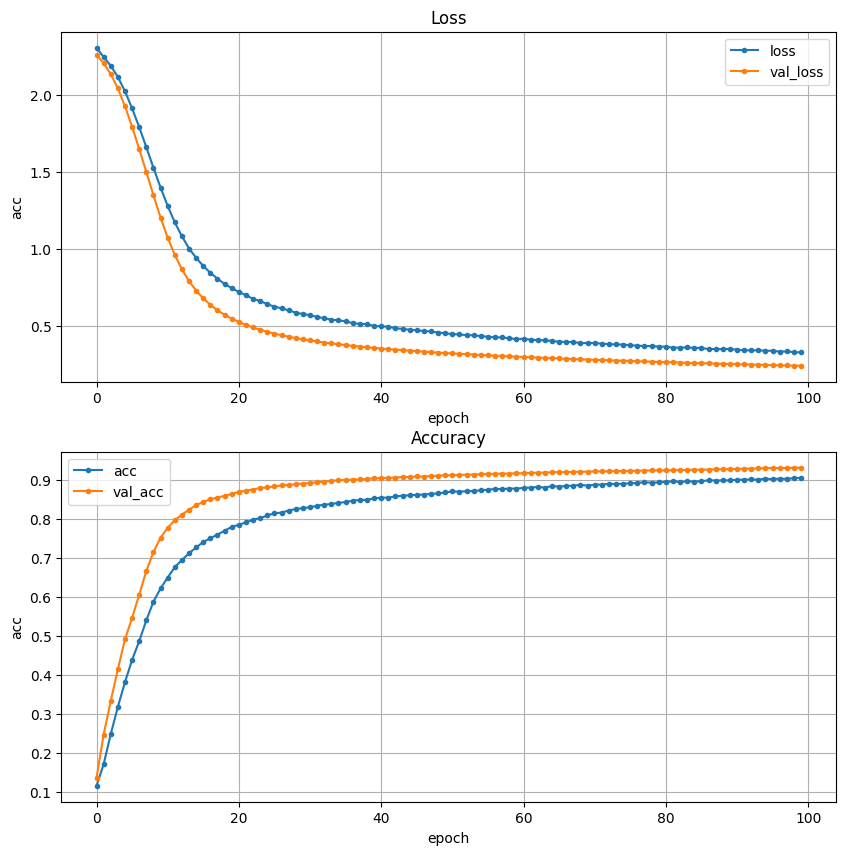

In [7]:
# 学習の様子をプロット
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Loss')
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')

plt.subplot(2,1,2)
plt.title('Accuracy')
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig('./output/result.png')
plt.show()

In [45]:
import numpy as np
from PIL import Image
import os

with os.scandir('./input') as entries:
    items = [entry.name for entry in entries if entry.is_file()]

data = []
file_name = []

for file in items:
    data.append(Image.open(f'./input/{file}').convert('L'))
    file_name.append(file)

data = np.array(data)
x_pre = data.reshape(len(data), 784)
x_pre = x_pre.astype('float32')
x_pre /= 255
y_pre = model.predict(x_pre)
print(y_pre)

for i in range(len(data)):
    print(file_name[i], np.argmax(y_pre[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[2.53280681e-02 3.90370972e-02 1.64022461e-01 6.49486259e-02
  2.66768988e-02 2.25748885e-02 1.38905849e-02 6.00509703e-01
  5.81026217e-03 3.72014455e-02]
 [3.50328791e-03 6.87772455e-03 8.87964427e-01 4.49268818e-02
  6.46209985e-04 4.12134221e-03 1.47220539e-02 7.68110761e-03
  2.88424324e-02 7.14549038e-04]
 [1.91741716e-02 3.37958485e-02 6.27725646e-02 4.68138218e-01
  1.92392897e-02 1.26685858e-01 1.04254670e-02 1.48443028e-01
  2.96791252e-02 8.16464052e-02]
 [4.20501493e-02 2.98768487e-02 9.70385671e-02 5.45097422e-03
  2.14146197e-01 9.00866091e-02 4.26115990e-01 5.06218802e-03
  5.00461347e-02 4.01264131e-02]
 [3.09316907e-02 1.46485474e-02 2.84660924e-02 6.12768643e-02
  5.86619526e-02 4.35889184e-01 2.61160322e-02 1.96792111e-02
  1.33628577e-01 1.90701857e-01]
 [2.70063225e-02 1.99093241e-02 6.84138527e-03 4.58640978e-02
  1.31516550e-02 7.23542571e-01 1.05114905e-02 3.68566369e-03
  1.22310251e-01 2.71772519e-02]
 [6.56695813e-02 1.0

In [8]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
import tensorflow as tf
tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


False